# **NOTEBOOK PLS**

Al momento potresti cominciare in modo semplice con il segnale BOLD provando la seguente cosa per uno dei film (poi puoi andare per tutti i 14):
- **X = Nsubjs x N_brain_features** =  Matrice contenente per ogni soggetto  il vettore di upper triangular values dei connettomi di ciascun soggetti <br>
/media/miplab-nas2/Data2/Movies_Emo/Flavia_E3/Data/TC_114*)
- **Y = Nsubjs x N_behavioural_features** = Matrice contenente per ogni soggetto i behaviour  <br>
/media/miplab-nas2/Data2/Movies_Emo/BIDS/TheRealfMRIStudy/rawdata/participants.tsv <br>


In [1]:
import pandas as pd
from plot import *
from compute import *
import seaborn as sns
import matplotlib.pyplot as plt

Read the data

In [2]:
# Load the Y behavioural dataset
PATH_DATA = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/'
columns = ['DASS_dep', 'DASS_anx', 'DASS_str',	'bas_d', 'bas_f', 'bas_r', 'bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope']

Y = pd.read_csv(PATH_DATA + 'participants.tsv', sep='\t', header=0)[columns]
print('The shape of the Y behavioural dataset is: ', Y.shape)
Y.head()

The shape of the Y behavioural dataset is:  (30, 12)


,DASS_dep,DASS_anx,DASS_str,bas_d,bas_f,bas_r,bis,BIG5_ext,BIG5_agr,BIG5_con,BIG5_neu,BIG5_ope
0,0,2,1,3.50,3.25,4.0,2.857143,31,40,34,27,40
1,1,0,0,3.50,2.75,3.0,2.142857,29,32,35,19,36
2,4,7,14,2.50,3.25,3.2,3.285714,22,29,32,26,47
3,0,2,2,3.25,3.00,3.8,3.285714,35,45,43,21,42
4,5,2,9,3.25,3.50,3.0,3.285714,21,36,30,22,42


We nwo created the X and Y matrices. It's now time to compute the PLSC behavioural algorithm. <br>

**PLS** is a multivariate method that finds linear combinations of the two matrices that are maximally correlated. <br>
The algorithm is as follows: <br>

0. Normalize and centre the data: **X_n = X - mean(X)** and **Y_n = Y - mean(Y)** 
1. Compute the covariance matrix between X and Y: **R_beh_n = YT_beh_n • X_n**
2. Compute the SVD of R_beh_n: **R_beh_n = U_beh_n • S_beh_n • V_beh_nT**
3. From the saliences **U_beh_n** and **V_beh_nT** compute the latent variables **LV_beh_n = U_beh_n • S_beh_n** and **LV_brain_n = V_beh_nT • S_beh_n**
4. Use PCA to reduce the dimensionality of the latent variables **LV_beh_n** and **LV_brain_n**


The PLS was already computed for you and saved in the folder: <br>
**'/Users/silviaromanato/Desktop/ServerMIPLAB/Silvia/Data/Output'**

In [3]:
list_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Rest', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']

## **ALL YEO NETWORKS; CONCAT MOVIES**

In [5]:
df_all = pd.DataFrame(columns = ['P-value', 'Covariance Explained', 'Type', 'Region'])
list_functionalnetworks = ['ALL', 'DA', 'DMN', 'FP', 'L', 'SC', 'SM', 'VA', 'VIS']

for method in ['bold']:

    df_fn = pd.DataFrame(columns = ['P-value', 'Covariance Explained', 'Type', 'Region'])
    for fn in list_functionalnetworks:
        PATH = f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_{method}_{fn}_concatmovies.csv'
        df = pd.read_csv(PATH, index_col=0).reset_index()
        if df.shape[0] == 0:
            df = pd.DataFrame({'P-value': 0.0, 'Covariance Explained' : 0.0, 'Type': 'bold', 'Region': fn}, index=[0])
        df['Type'] = f'{method}'
        df['Region'] = f'{fn}'
        significant = df[df['P-value'] <= 0.05][['P-value', 'Covariance Explained', 'Type', 'Region']]
        df_fn = pd.concat([df_fn, significant], ignore_index=True)
            
    df_all = pd.concat([df_all, df_fn], ignore_index=True)

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x1000 with 0 Axes>

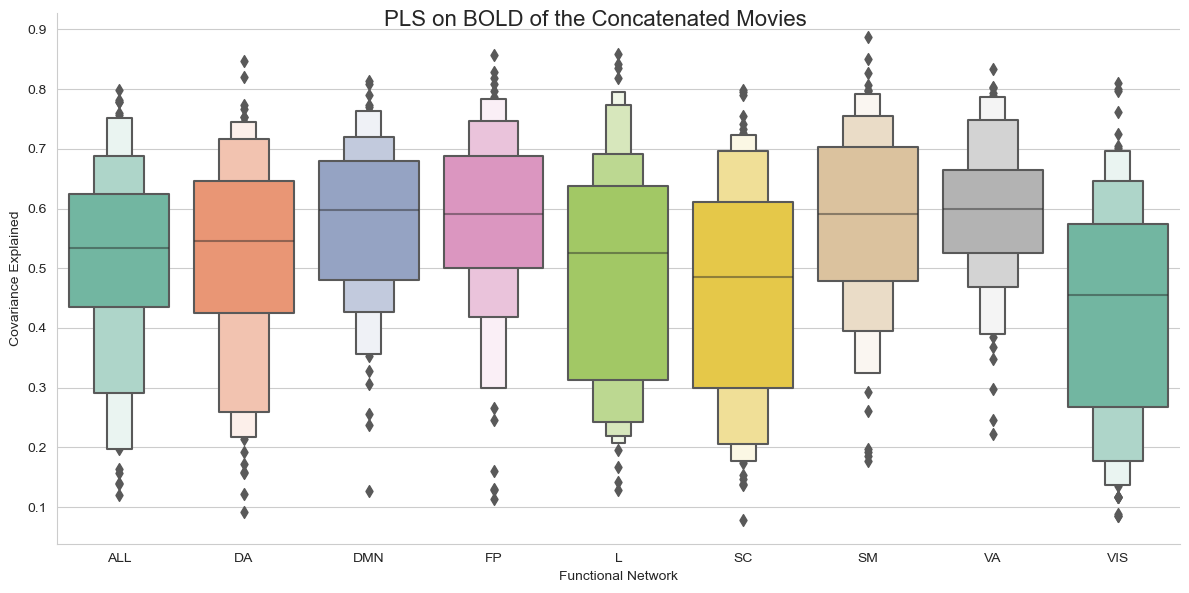

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette("Set2")
plt.figure(figsize=(20, 10))
g = sns.catplot(data=df_all, x='Region', y='Covariance Explained', kind = 'boxen', height=6,
                aspect=2, palette=palette)
g.fig.suptitle('PLS on BOLD of the Concatenated Movies', fontsize=16)
g.set(xlabel='Functional Network', ylabel='Covariance Explained')
sns.set_style("whitegrid")
plt.show()

## **BOOTSTRAPPING whole brain**

In [53]:
list_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Rest', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']

list_functionalnetworks = ['ALL']
list_methods = ['bold', 'scaffold', 'triangles']

def bootstrap_data(list_methods, list_functionalnetworks, verbose = False):
    
    df_bootstrap = pd.DataFrame(columns = ['Movie', 'P-value', 'Covariance Explained', 'Type', 'LC', 'Region'])
    for method in list_methods: 
        
        df_fn = pd.DataFrame(columns = ['Movie', 'P-value', 'Covariance Explained', 'Type', 'LC', 'Region'])
        for fn in list_functionalnetworks:
            if verbose:
                print(method, fn)
            
            PATH = f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_{method}_{fn}_bootstrap_results.csv'
            df = pd.read_csv(PATH, index_col=0).reset_index()

            # add the bootstrap round columns
            n_movies = df.Movie.unique()
            a = np.repeat(np.arange(1,101), df.shape[0] / 100 / len(n_movies))
            for i in range(n_movies.shape[0]-1):
                a = np.concatenate((a, np.repeat(np.arange(1,101), df.shape[0] / 100 / len(n_movies))), axis = 0)

            df['bootstrap_round'] = a

            df['Type'] = f'{method}'
            significant = df[df['P-value'] <= 0.05]

            notin = [x for x in list_movies if x not in significant.Movie.unique()]
            for movie in notin:
                new_row = {'Movie': f'{movie}', 'P-value': 0.0, 'Covariance Explained': 0.0, 'Type': f'{method}', 'LC': '1', 'Region': f'{fn}'}
                significant =  pd.concat([significant, pd.DataFrame([new_row])], ignore_index=True)
                if verbose:
                    print('added: ', movie)

            df_lc = significant.groupby(['Movie', 'bootstrap_round', 'Region', 'Type']).sum().reset_index()
            df_fn = pd.concat([df_fn, df_lc], ignore_index=True)
        
        df_bootstrap = pd.concat([df_bootstrap, df_fn], ignore_index=True)

    df_bootstrap['Movie_Type'] = df_bootstrap['Movie'] + '_' + df_bootstrap['Type']
    df_bootstrap = df_bootstrap.sort_values(by=['Movie_Type', 'Region', 'Type'])

    return df_bootstrap

df_bootstrap = bootstrap_data(list_methods, list_functionalnetworks)

bold ALL
(18000, 5) 12.0
(18000,)
scaffold ALL
(18000, 5) 12.0
(18000,)
triangles ALL
(13200, 5) 8.8
(13200,)


In [44]:
18000 / 100 / 15

12.0

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x1000 with 0 Axes>

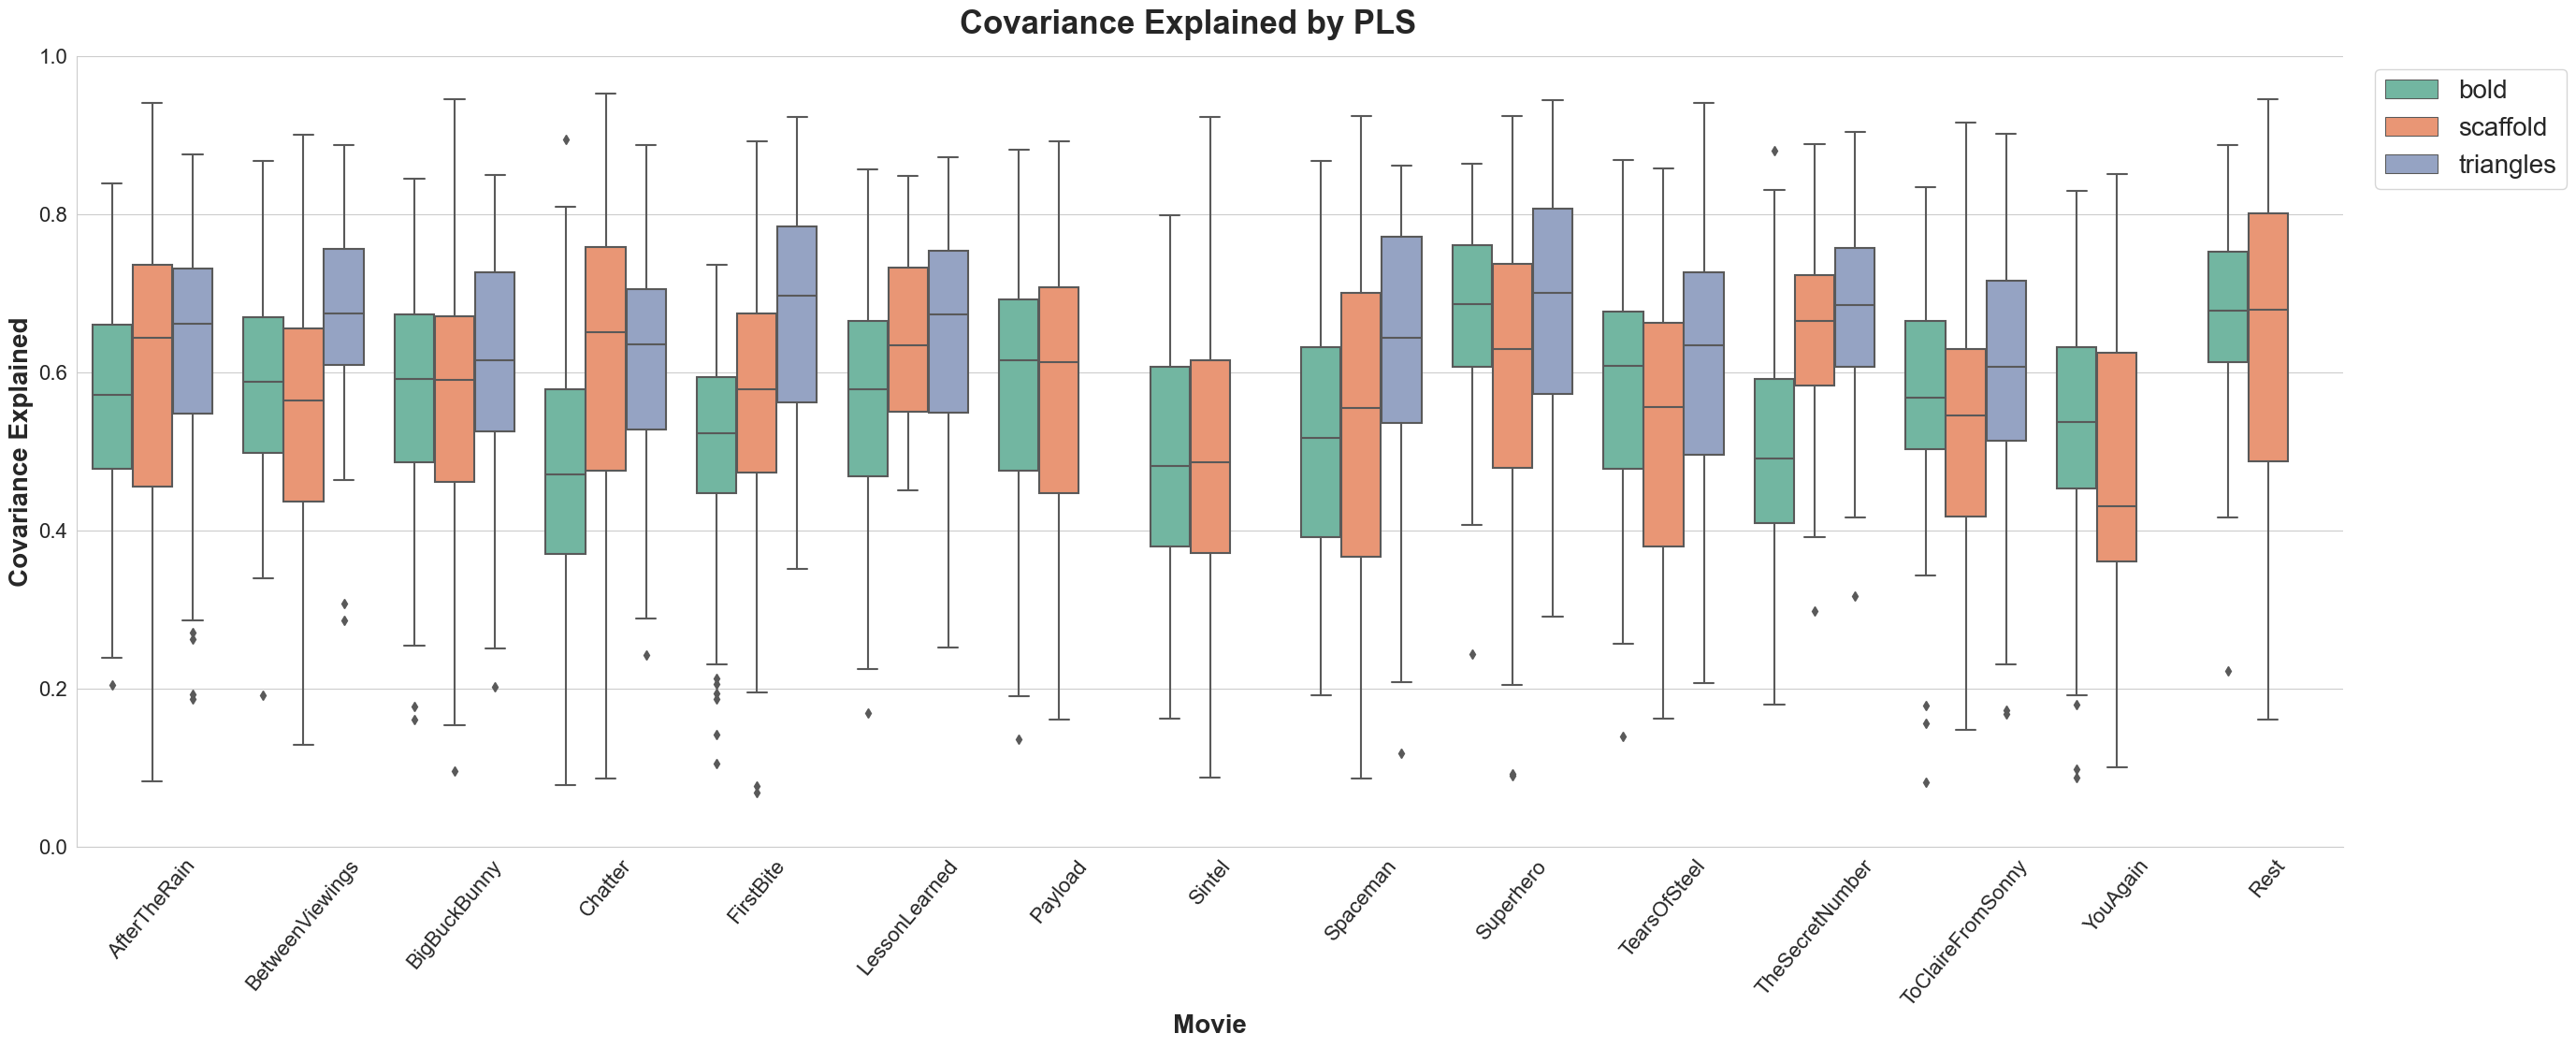

In [27]:
palette = sns.color_palette("Set2")
plt.figure(figsize=(10, 10))
plt.tight_layout()
order_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 
                'LessonLearned', 'Payload', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 
                'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain', 'Rest']

g = sns.catplot(data=df_bootstrap, x='Movie', y='Covariance Explained', hue='Type', kind='box', height=10,
                aspect= 2.5, palette=palette, order=order_movies, legend_out=False)
# sns.stripplot(data=df_bootstrap, x='Movie', y='Covariance Explained', hue='Type', dodge=True, size=5, palette=palette, order=order_movies)

g.set_xticklabels(rotation=50, fontsize=16)
g.set_yticklabels(fontsize=16)
g.fig.suptitle('Covariance Explained by PLS', fontsize=25, fontweight='bold', y=0.95)
g.fig.subplots_adjust(top=0.9)
g.set_axis_labels("Movie", "Covariance Explained", fontsize=20, fontweight='bold')
sns.set_style("whitegrid")
plt.ylim(0, 1.00)
g._legend.remove()
g.fig.legend(loc='upper right', bbox_to_anchor=(1.095, 0.9), fontsize=20)

plt.show()


## **BOOTSTRAPPING ON YEO NETWORKS**

In [40]:
df_all = pd.DataFrame(columns = ['Movie', 'P-value', 'Covariance Explained', 'Type', 'LC', 'Region'])
list_functionalnetworks = ['DA', 'DMN', 'VIS', 'FP', 'SM', 'VA','L', 'SC']

for method in ['bold', 'triangles', 'scaffold']:

    df_fn = pd.DataFrame(columns = ['Movie', 'P-value', 'Covariance Explained', 'Type', 'LC', 'Region'])
    for fn in list_functionalnetworks:
        PATH = f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_{method}_{fn}_results.csv'
        df = pd.read_csv(PATH)
        df = df.drop_duplicates(subset = ['Movie', 'LC'])

        # add the bootstrap round columns
        n_movies = df.Movie.unique()
        a = np.repeat(np.arange(1,101), 12)
        for i in range(n_movies.shape[0]-1):
            a = np.concatenate((a, np.repeat(np.arange(1,101), 12)), axis = 0)
        df['bootstrap_round'] = a
        df['Type'] = f'{method}'
        df['Region'] = f'{fn}'

        significant = df[df['P-value'] < 0.05]

        notin = [x for x in list_movies if x not in significant.Movie.unique()]

        for movie in notin:
            new_row = {'Movie': f'{movie}', 'P-value': 0.0, 'Covariance Explained': 0.0, 'Type': f'{method}', 'LC': '1', 'Region': f'{fn}'}
            significant =  pd.concat([significant, pd.DataFrame([new_row])], ignore_index=True)
            #print('added: ', movie)

        df_fn = pd.concat([df_fn, significant], ignore_index=True)
            
    df_all = pd.concat([df_all, df_fn], ignore_index=True)


df_all = df_all.sort_values(by=['Movie', 'Region', 'Type'])
df_all = df_all.groupby(['Movie', 'Region', 'Type'])[['Covariance Explained', 'P-value']].sum().reset_index()

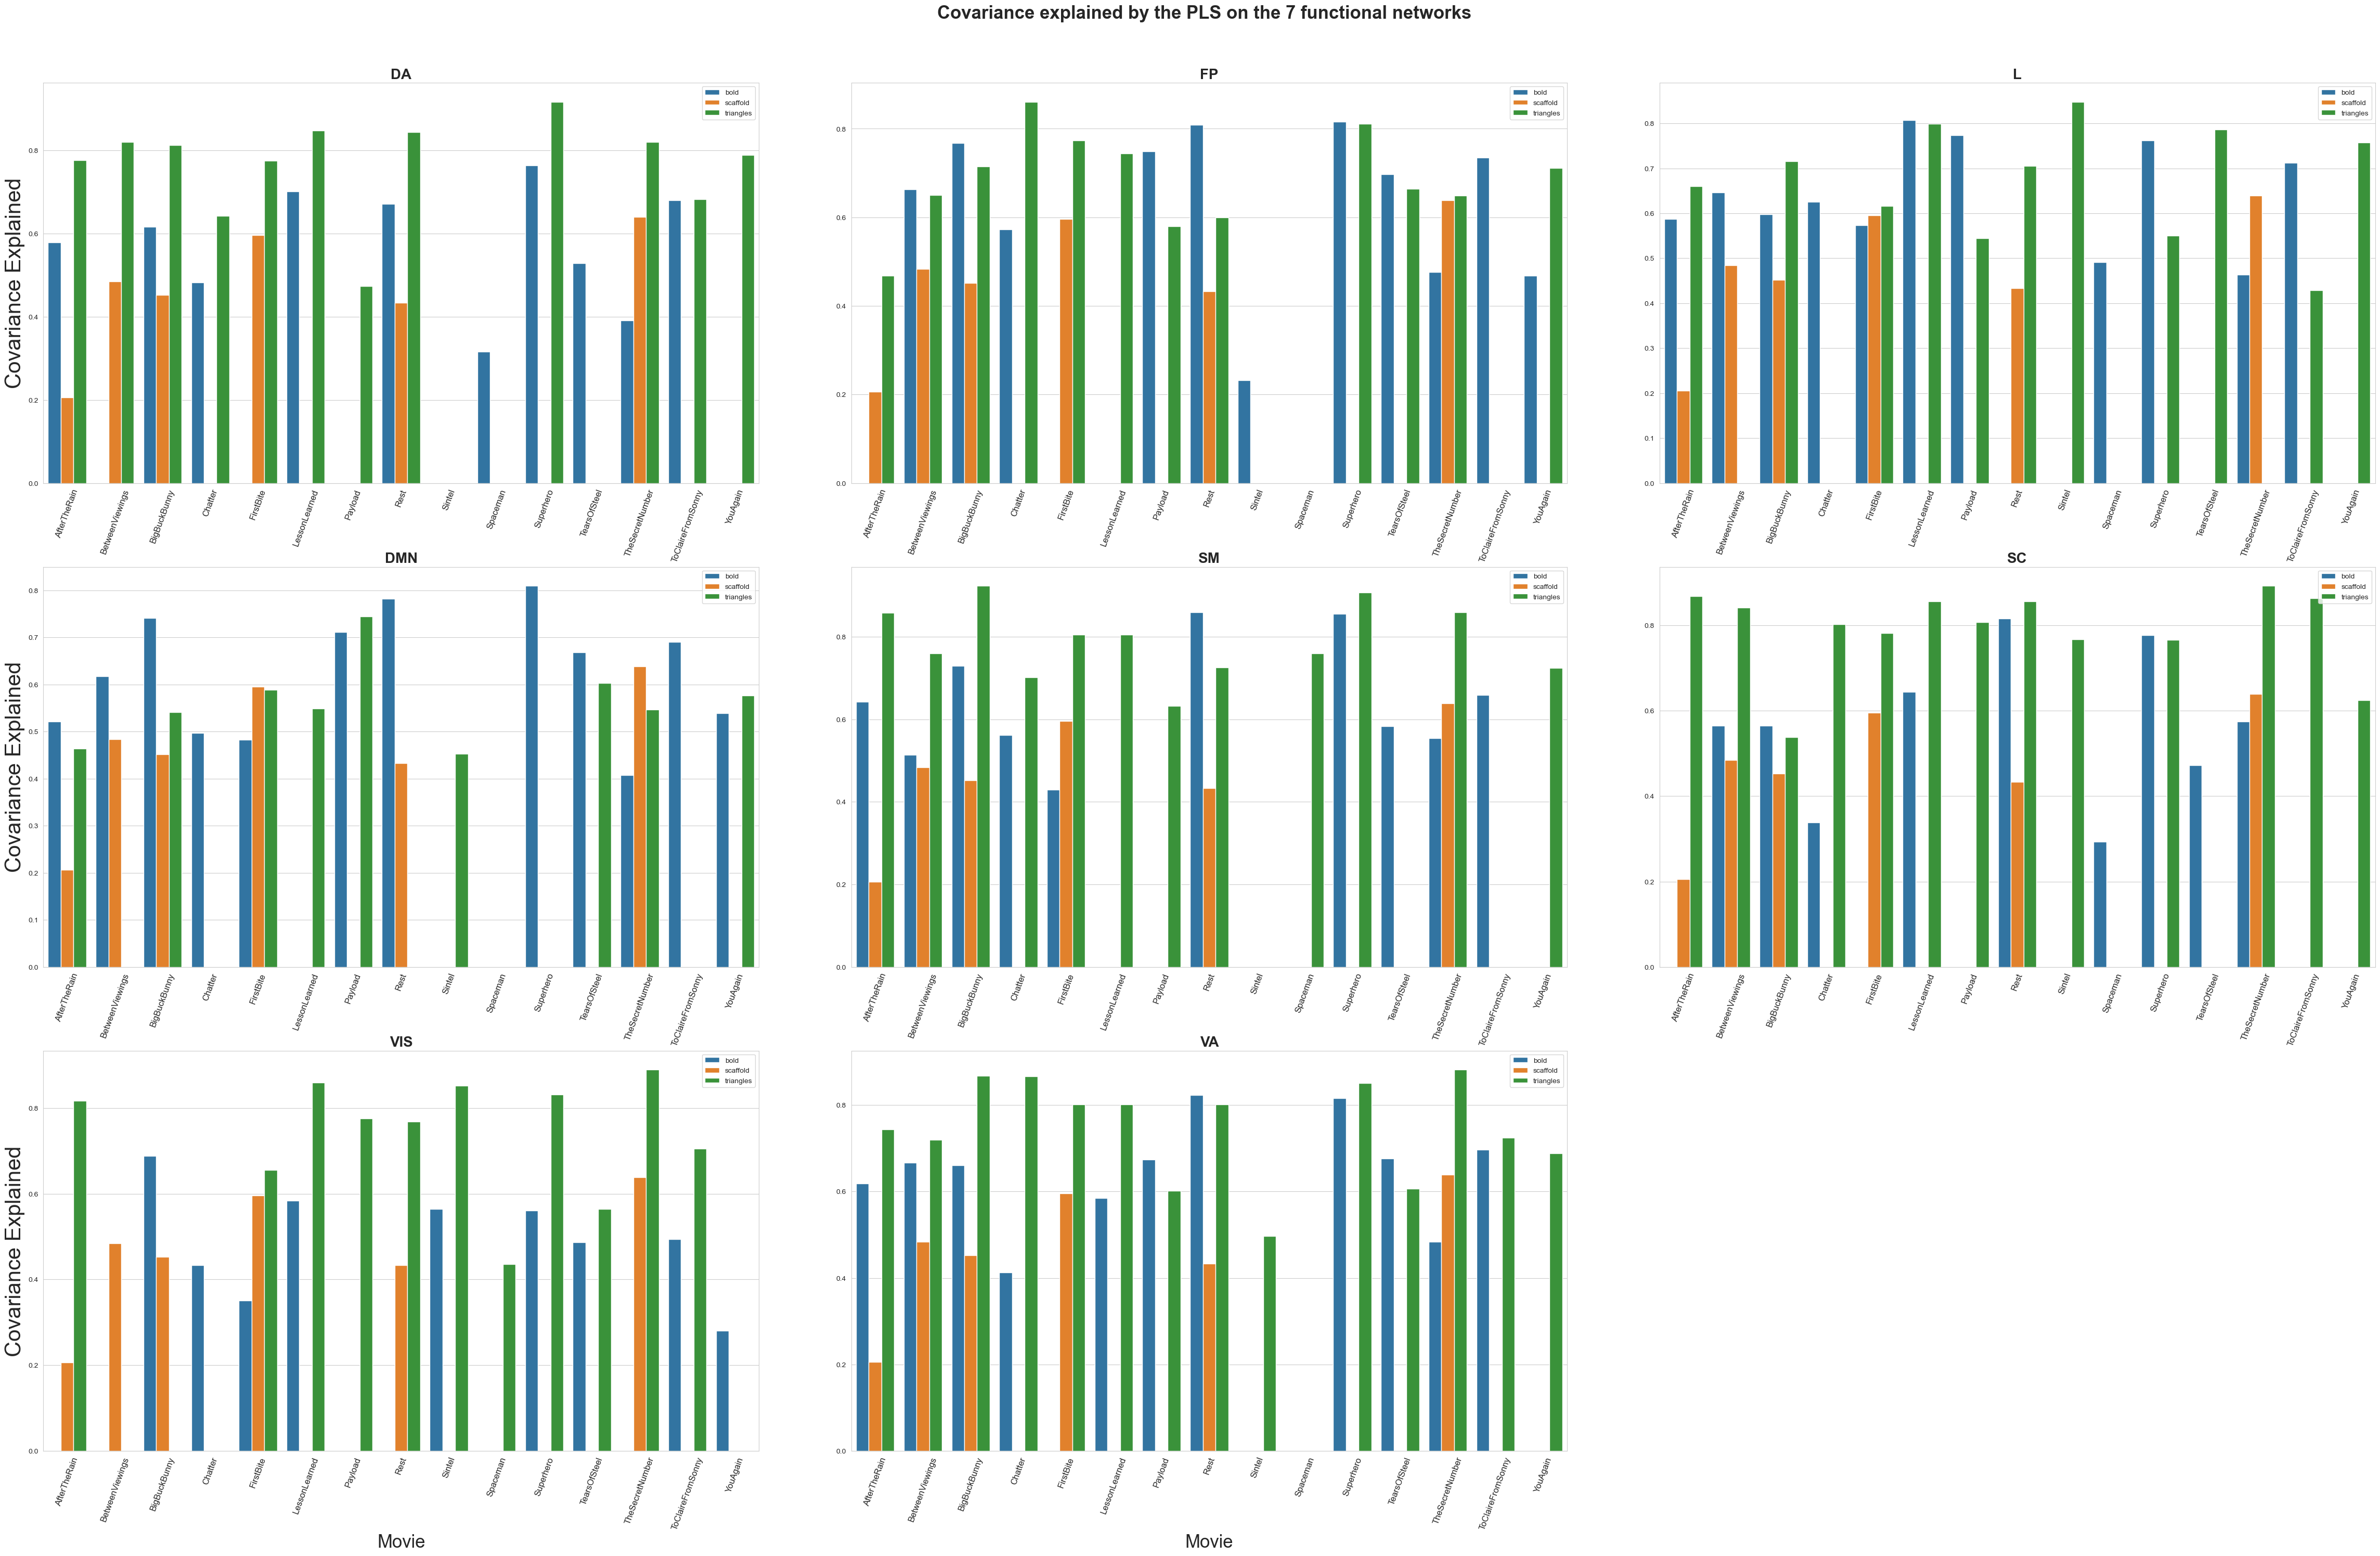

In [43]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(len(list_functionalnetworks) * 6, 30))
palette = sns.color_palette("Set2")
axes[2, 2].remove()
fig.tight_layout(pad=10)
for i, network in enumerate(list_functionalnetworks):
    row = i % 3
    col = i // 3
    network_df = df_all[df_all['Region'] == network]

    ########### PLOT ###########
    sns.barplot(network_df, ax = axes[row, col], x='Movie', y='Covariance Explained', hue='Type')
    # remove the x labels and the y labels
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('')
    axes[row, col].set_title(network, fontsize=20, fontweight='bold')
    if row == 2:
        axes[row, col].set_xlabel('Movie', fontsize=25)
    if row == 1 & col == 2:
        axes[row, col].set_xlabel('Movie', fontsize=25)
    if col == 0:
        axes[row, col].set_ylabel('Covariance Explained', fontsize=30)
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=70, fontsize=12)
    axes[row, col].legend(loc='upper right')

fig.suptitle('Covariance explained by the PLS on the 7 functional networks', fontsize=25, fontweight='bold')
plt.subplots_adjust(top=0.93)


## Bootstrap

In [41]:
PATH = f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_bold_L_bootstrap_results.csv'
df = pd.read_csv(PATH, index_col=0).reset_index()
# count
df.groupby(['Movie', 'Region']).count().reset_index()

,Movie,Region,Covariance Explained,P-value,LC
0,AfterTheRain,L,1000,1000,1000
1,BetweenViewings,L,1000,1000,1000
2,BigBuckBunny,L,1000,1000,1000
3,Chatter,L,1000,1000,1000
4,FirstBite,L,1000,1000,1000
5,LessonLearned,L,1000,1000,1000
6,Payload,L,1000,1000,1000
7,Rest,L,1000,1000,1000
8,Sintel,L,1000,1000,1000
9,Spaceman,L,1000,1000,1000


In [54]:
list_methods = ['bold', 'scaffold', 'triangles']
list_functionalnetworks = ['DA', 'DMN', 'FP', 'SC', 'SM', 'VA', 'VIS', 'L']

df_bootstrap = bootstrap_data(list_methods, list_functionalnetworks)

bold DA
(18000, 5) 12.0
(18000,)
bold DMN


(18000, 5) 12.0
(18000,)
bold FP
(18000, 5) 12.0
(18000,)
bold SC
(18000, 5) 12.0
(18000,)
bold SM
(18000, 5) 12.0
(18000,)
bold VA
(18000, 5) 12.0
(18000,)
bold VIS
(18000, 5) 12.0
(18000,)
bold L
(15000, 5) 10.0
(15000,)
scaffold DA
(18000, 5) 12.0
(18000,)
scaffold DMN
(18000, 5) 12.0
(18000,)
scaffold FP
(18000, 5) 12.0
(18000,)
scaffold SC
(18000, 5) 12.0
(18000,)
scaffold SM
(18000, 5) 12.0
(18000,)
scaffold VA
(18000, 5) 12.0
(18000,)
scaffold VIS
(18000, 5) 12.0
(18000,)
scaffold L
(15000, 5) 10.0
(15000,)
triangles DA
(18000, 5) 12.0
(18000,)
triangles DMN
(18000, 5) 12.0
(18000,)
triangles FP
(18000, 5) 12.0
(18000,)
triangles SC
(18000, 5) 12.0
(18000,)
triangles SM
(18000, 5) 12.0
(18000,)
triangles VA
(18000, 5) 12.0
(18000,)
triangles VIS
(18000, 5) 12.0
(18000,)
triangles L
(15000, 5) 10.0
(15000,)


In [40]:
list_movies = ['Sintel', 'Superhero', 'TearsOfSteel', 'TheSecretNumber']

df_bootstrap = pd.DataFrame(columns = ['Movie', 'P-value', 'Covariance Explained', 'Type', 'LC', 'Region'])
list_functionalnetworks = ['DA', 'DMN', 'FP', 'L', 'SC', 'SM', 'VA', 'VIS']

for method in ['bold', 'scaffold', 'triangles']:

    df_fn = pd.DataFrame(columns = ['Movie', 'P-value', 'Covariance Explained', 'Type', 'LC', 'Region'])
    for fn in list_functionalnetworks:
        PATH = f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_{method}_{fn}_bootstrap_results.csv'
        df = pd.read_csv(PATH, index_col=0).reset_index()

        
        df['Type'] = f'{method}'

        significant = df[df['P-value'] <= 0.05]
        notin = [x for x in list_movies if x not in significant.Movie.unique()]

        for movie in notin:
            new_row = {'Movie': f'{movie}', 'P-value': 0.0, 'Covariance Explained': 0.0, 'Type': f'{method}', 'LC': '1', 'Region': f'{fn}'}
            significant =  pd.concat([significant, pd.DataFrame([new_row])], ignore_index=True)
            print('added: ', movie)

        # sum the lc by grouping by movie and bootstrap round and region and type
        df_lc = significant.groupby(['Movie', 'bootstrap_round', 'Region', 'Type']).sum().reset_index()
        
        df_fn = pd.concat([df_fn, significant], ignore_index=True)
            
    df_bootstrap = pd.concat([df_bootstrap, df_fn], ignore_index=True)

# movie in list_movies
df_bootstrap = df_bootstrap[df_bootstrap['Movie'].isin(list_movies)]

- - - - - - - - - - bold- - - - - - - - - - 
----------DA----------
----------DMN----------
----------FP----------
----------L----------
----------SC----------
----------SM----------
----------VA----------
----------VIS----------


In [45]:
# drop the networks L and SC
df_bootstrap = df_bootstrap[df_bootstrap['Region'] != 'L']
df_bootstrap = df_bootstrap[df_bootstrap['Region'] != 'SC']

<Axes: xlabel='Movie', ylabel='Covariance Explained'>

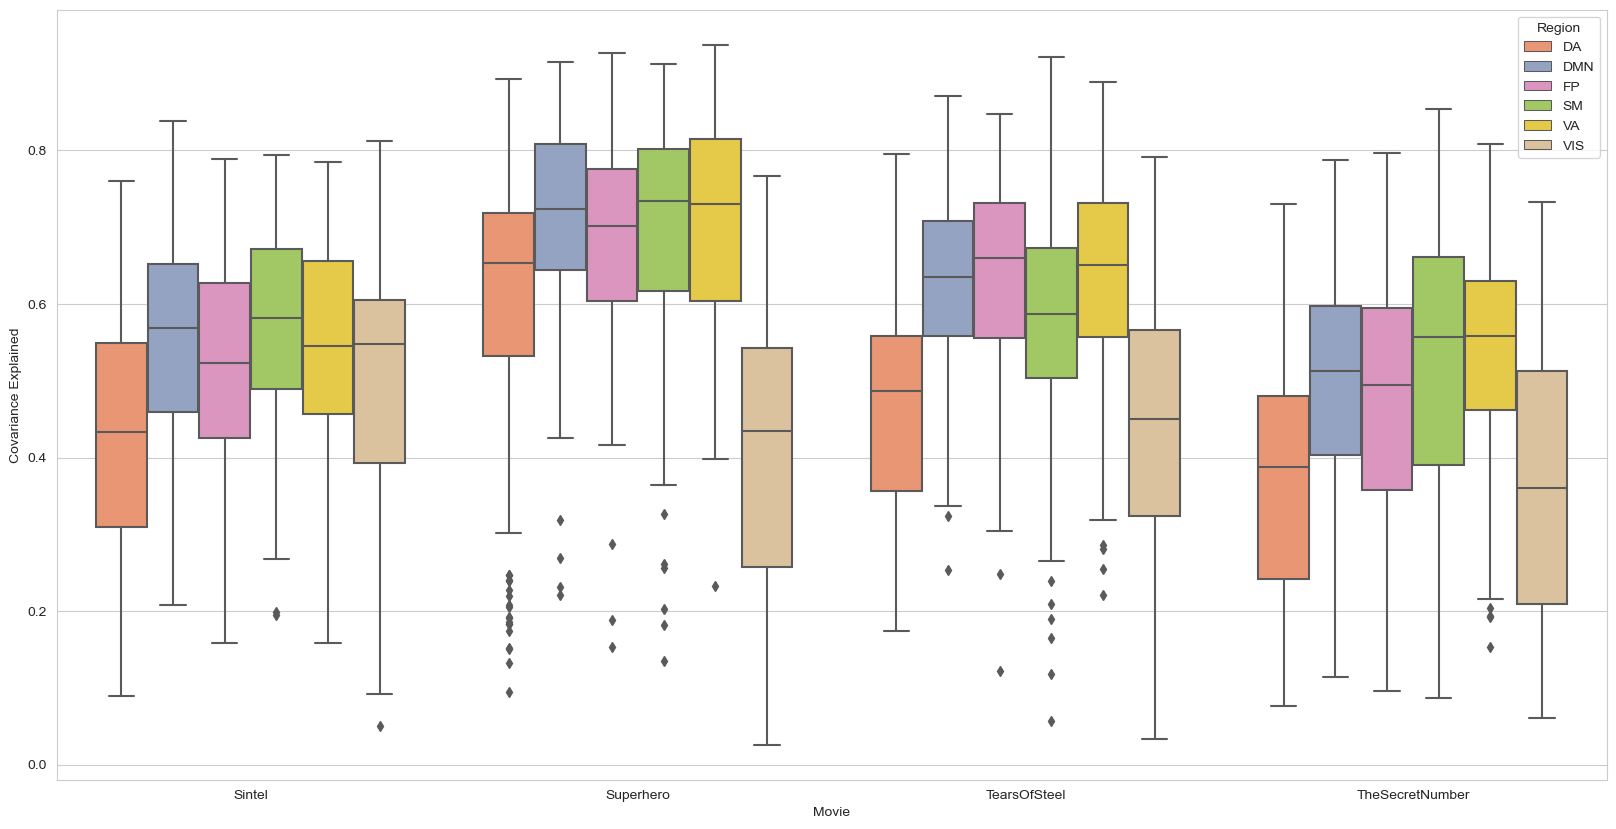

In [46]:
fig = plt.figure(figsize=(20, 10))
palette = sns.color_palette("Set2")[1:]
sns.boxplot(df_bootstrap, x='Movie', y='Covariance Explained', hue='Region', palette = palette)



ValueError: Could not generate a palette for <map object at 0x14b9ef7c0>

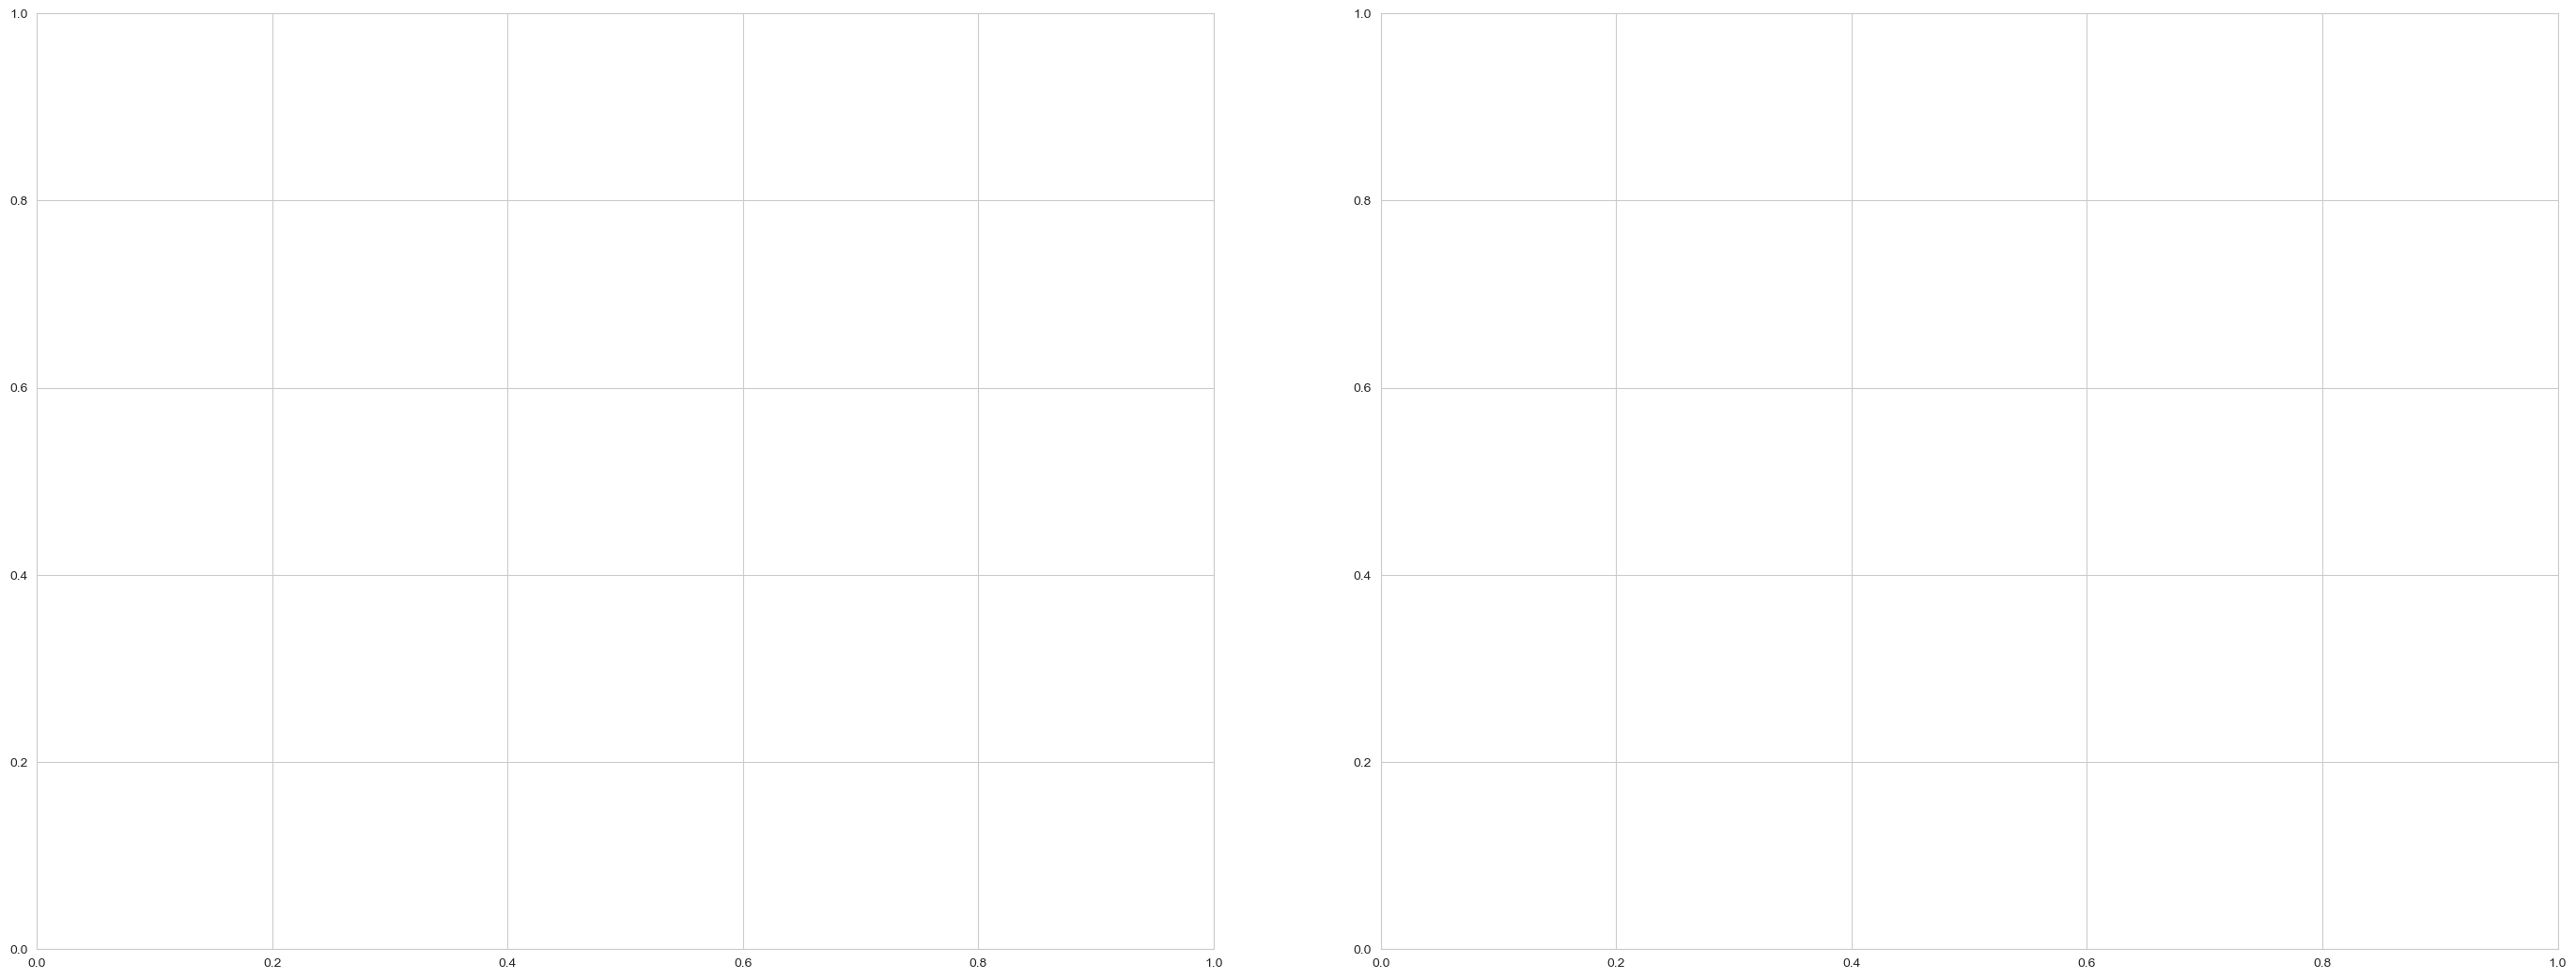

In [26]:
def plot_fn(df_bootstrap, networks):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(30, 13))
    palette = sns.color_palette("Set2")
    fig.tight_layout(pad=10)

    # VIS
    sns.boxplot(network_df, ax = axes[0], x='Movie', y='Covariance Explained', hue='Type', palette = palette)

    # remove the x labels and the y labels
    axes[0].set_title(networks[0], fontsize=20, fontweight='bold')
    axes[0].set_xlabel('Movie', fontsize=25)
    axes[0].set_xlabel('Movie', fontsize=25)
    axes[0].set_ylabel('Covariance Explained', fontsize=30)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=70, fontsize=12)
    axes[0].legend(loc='upper right')

    # SM
    network_df = df_bootstrap[df_bootstrap['Region'] == networks[1]]
    sns.boxplot(network_df, ax = axes[1], x='Movie', y='Covariance Explained', hue='Type', palette = palette)

    # remove the x labels and the y labels
    axes[1].set_title( networks[1], fontsize=20, fontweight='bold')
    axes[1].set_xlabel('Movie', fontsize=25)
    axes[1].set_xlabel('Movie', fontsize=25)
    axes[1].set_ylabel('Covariance Explained', fontsize=30)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=70, fontsize=12)
    axes[1].legend(loc='upper right')

    fig.suptitle(f'Covariance explained by {networks[0]} and {networks[1]} functional networks', fontsize=25, fontweight='bold')
    plt.subplots_adjust(top=0.93)

    plt.show()

plot_fn(df_bootstrap, ['VIS', 'SM'])

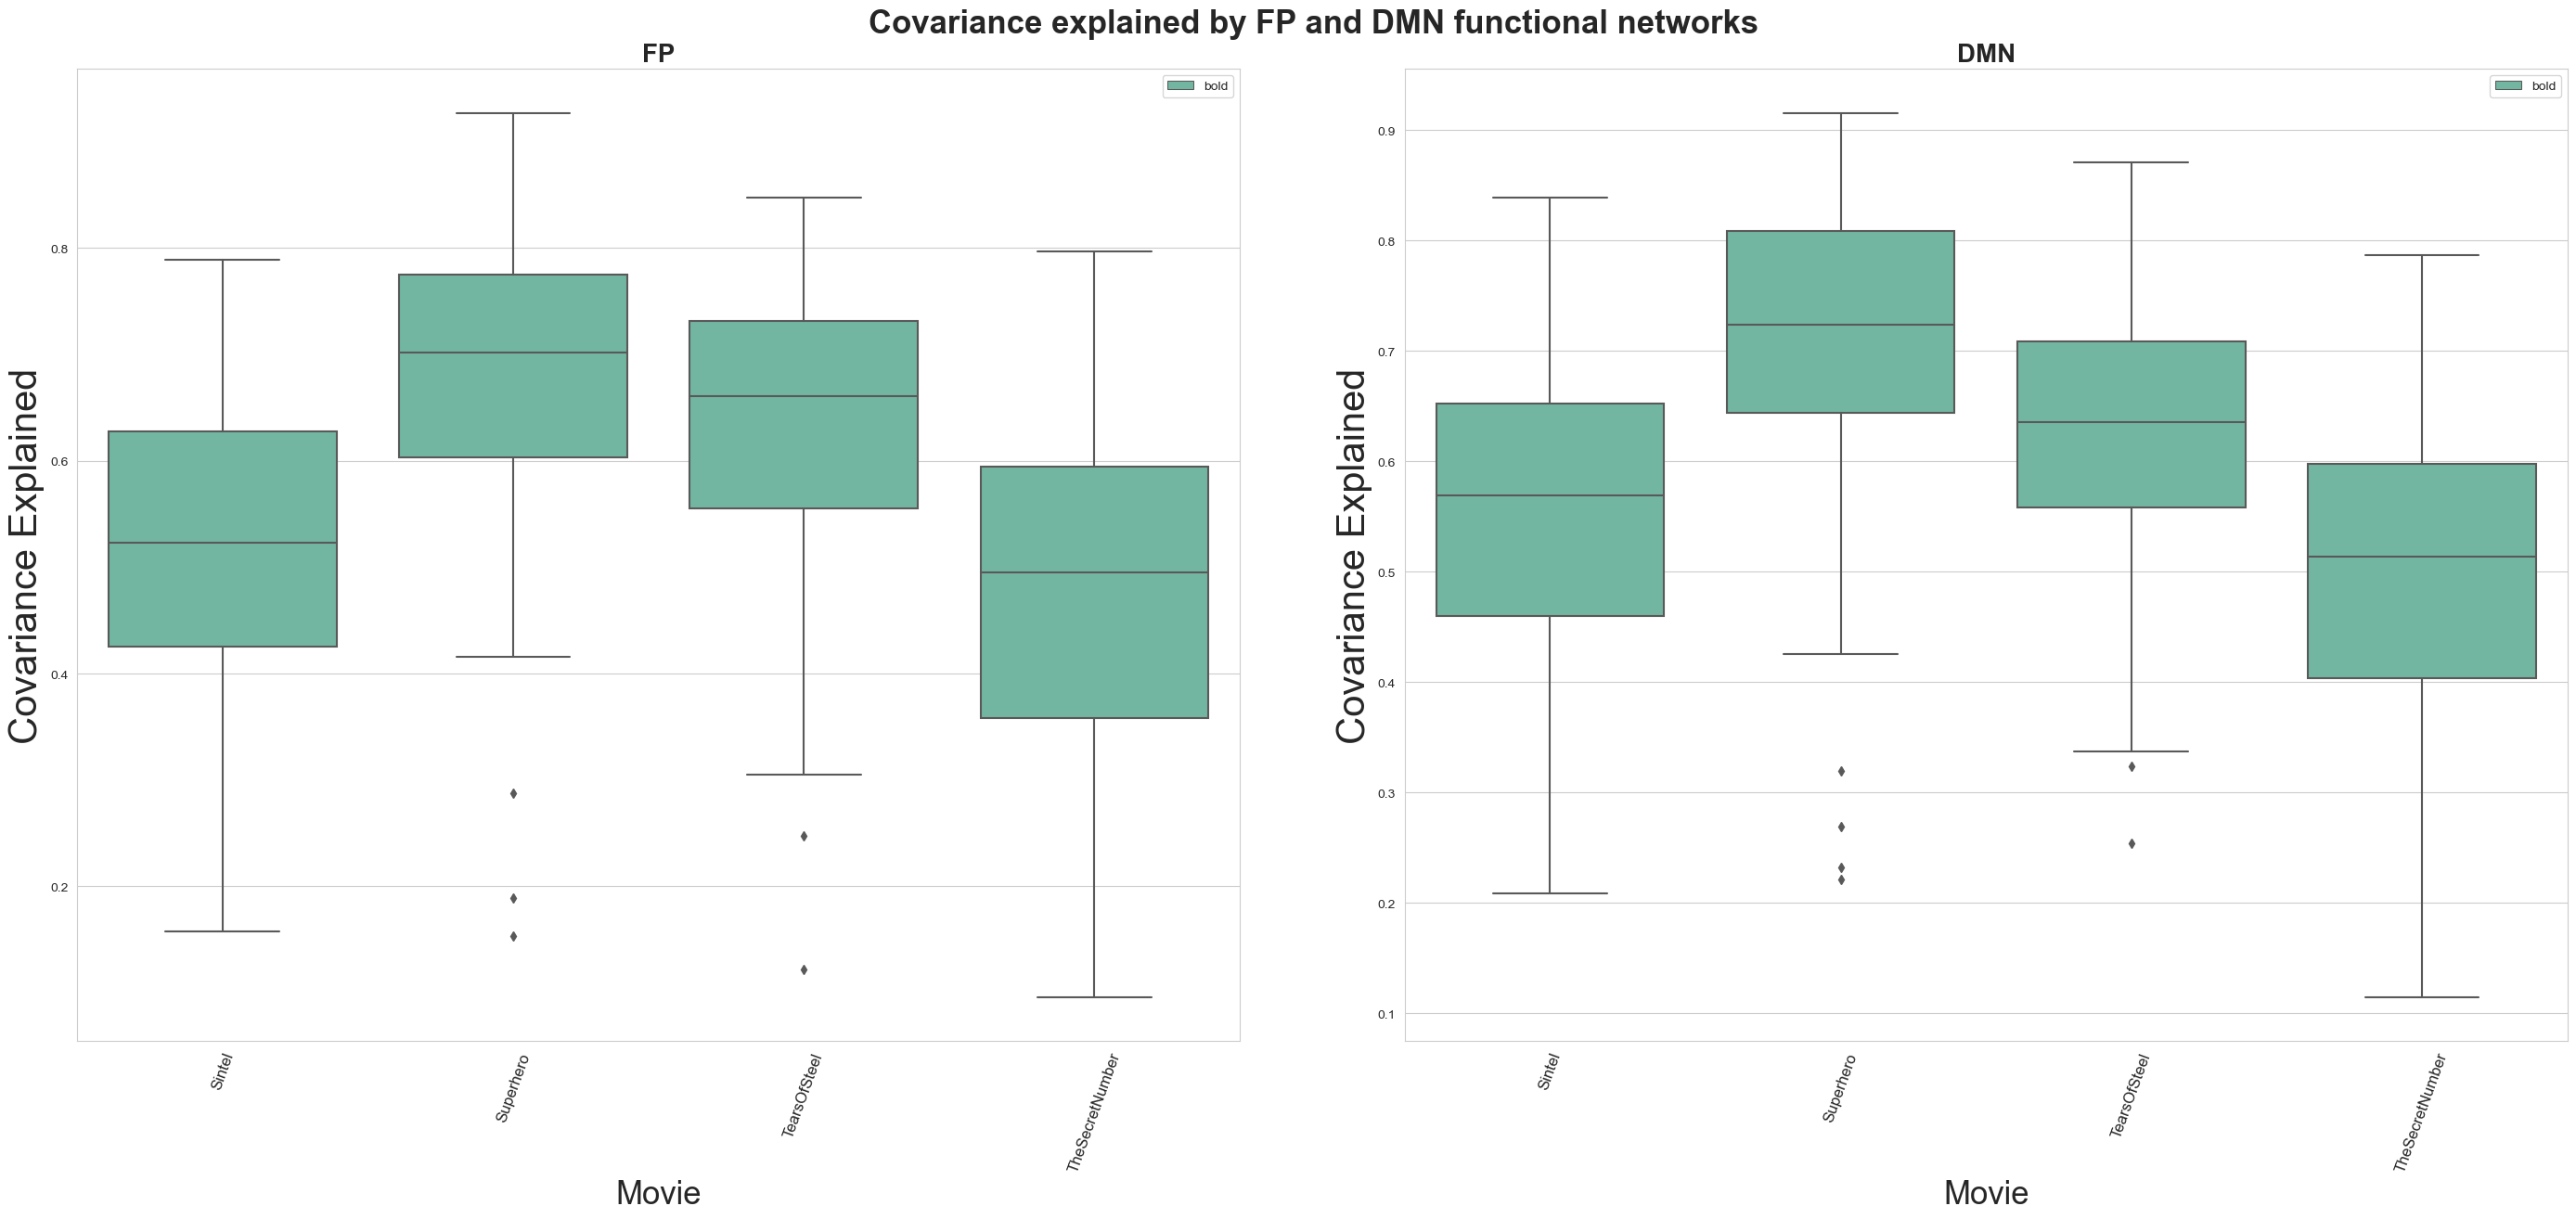

In [22]:
plot_fn(df_bootstrap, ['FP', 'DMN'])

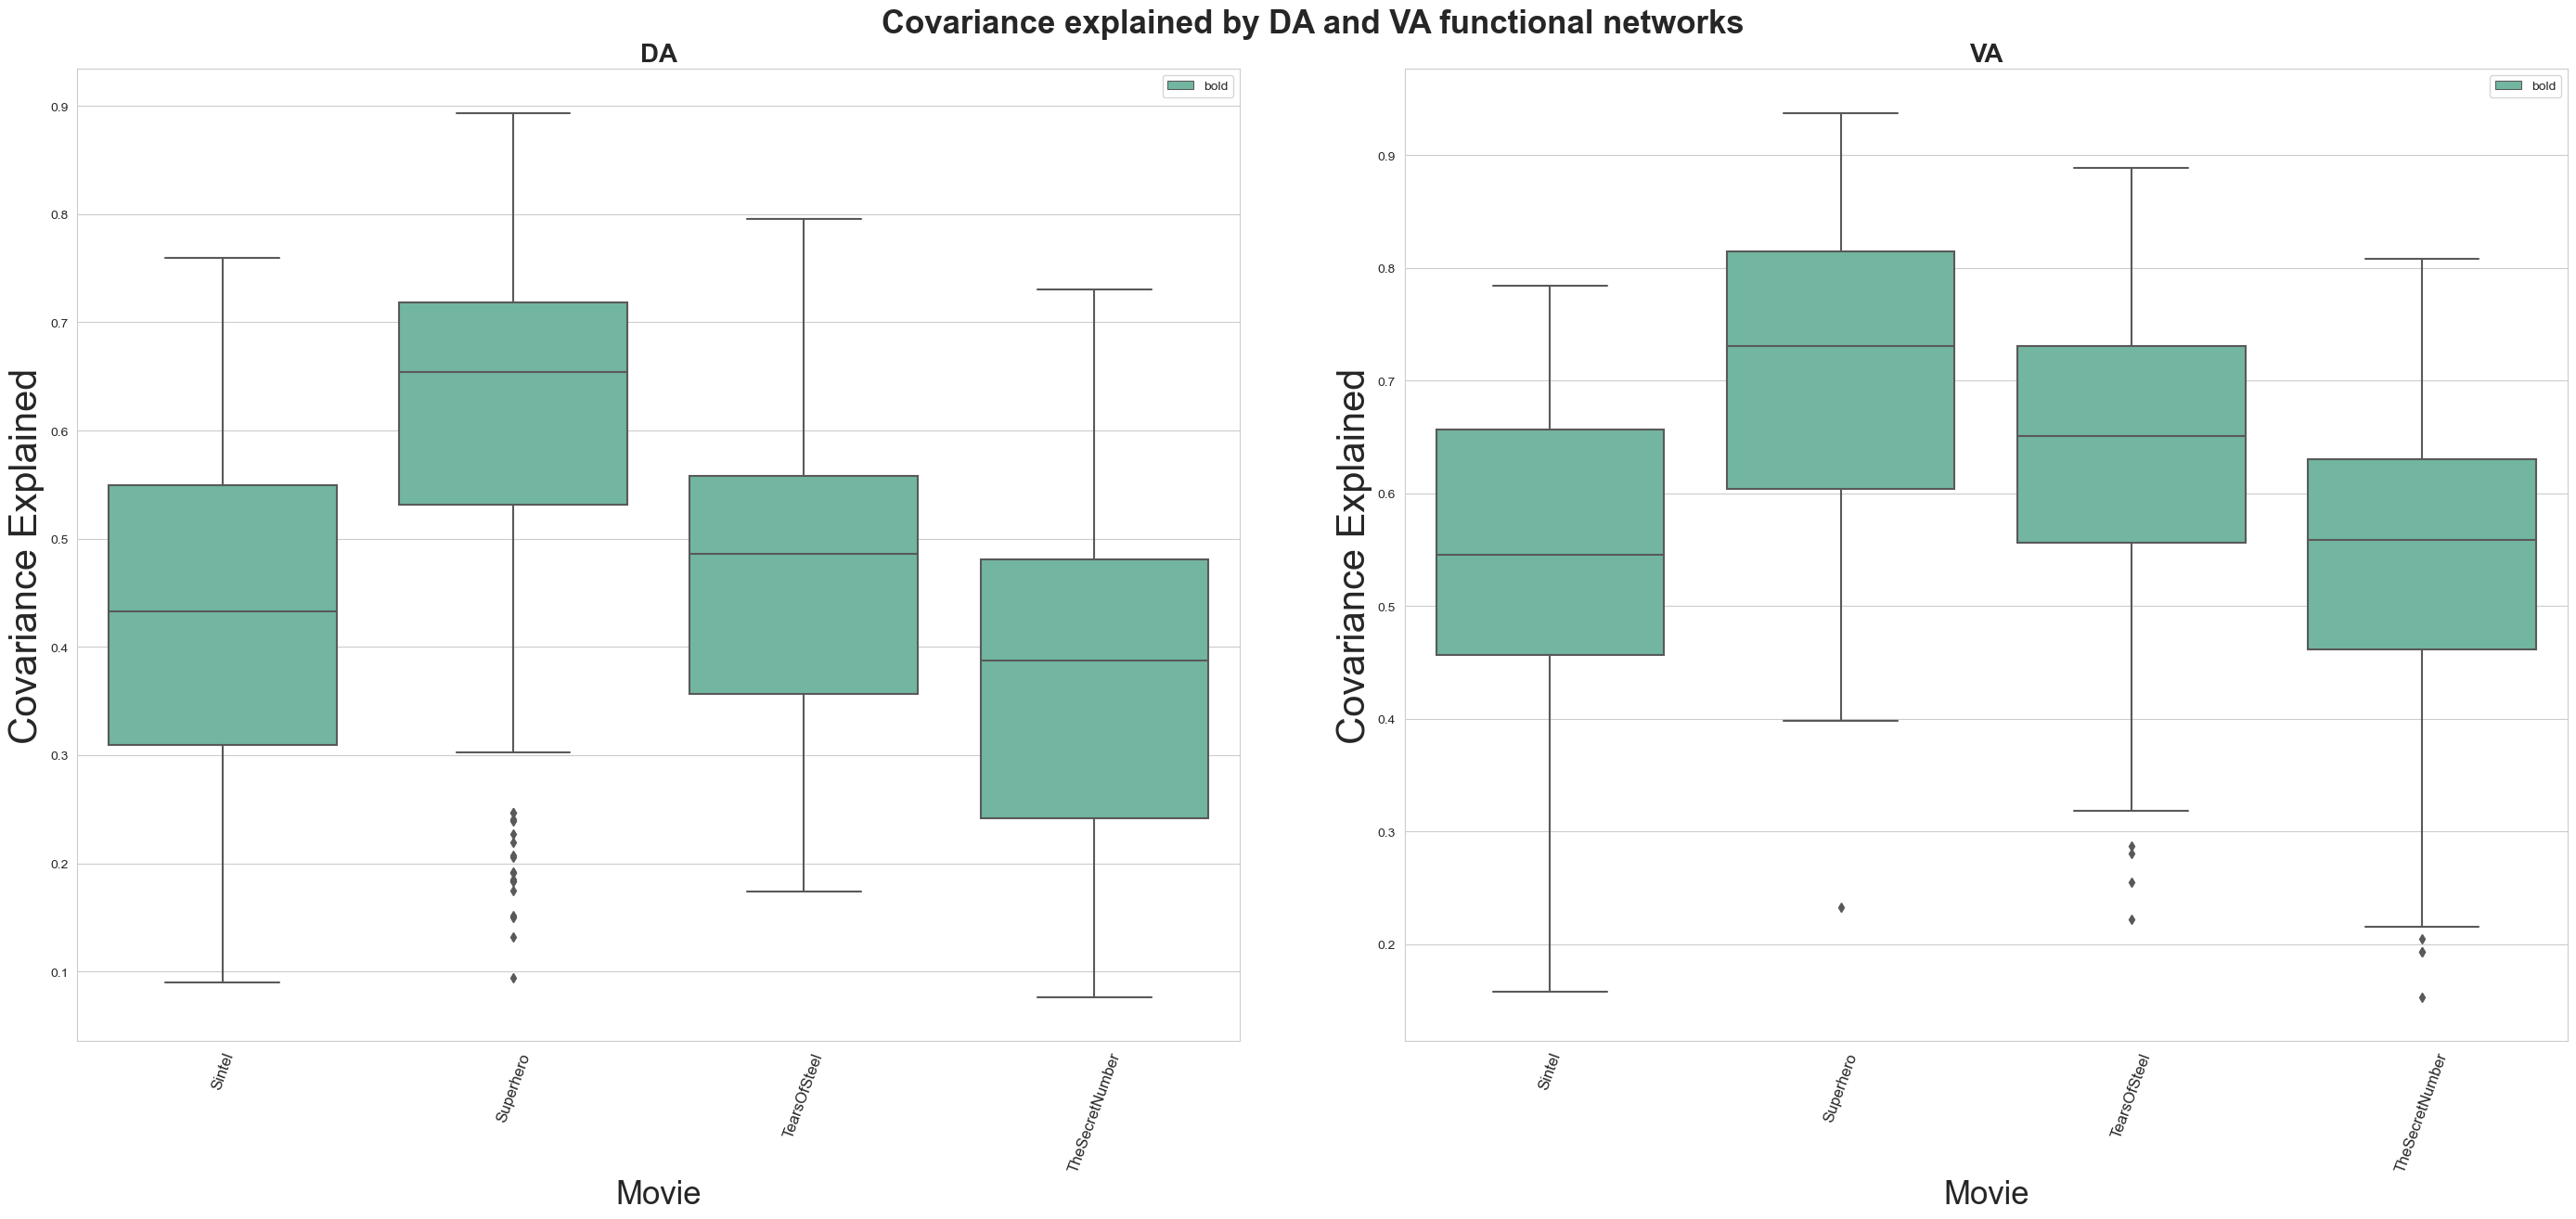

In [23]:
plot_fn(df_bootstrap, ['DA', 'VA'])

### **Difference between triangles and bootstrap**

ValueError: operands could not be broadcast together with shapes (0,) (4,) 

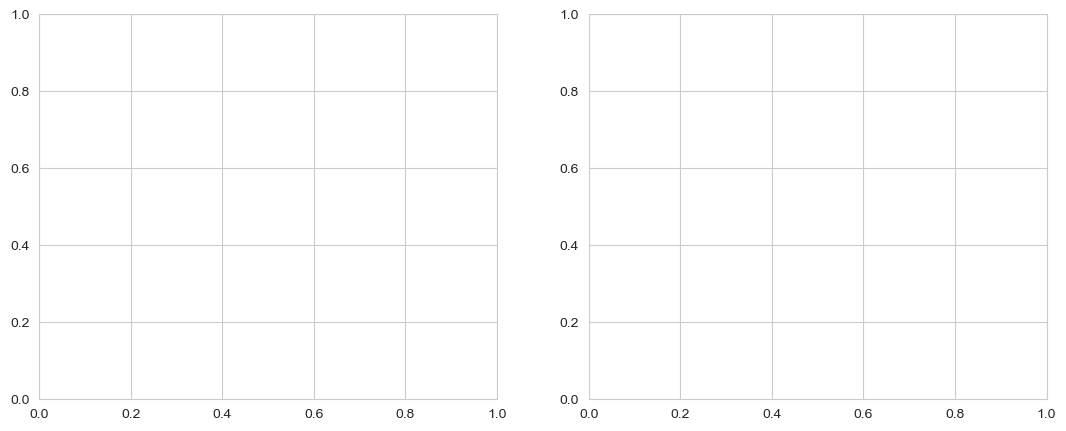

In [24]:
def plot_diff(df_bootstrap, networks):

    # create 2 subplots
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(13, 5))
    palette = sns.color_palette("Set2")
    
    # compute the mean and the standard deviation of the covariance explained by the PLS
    network_df = df_bootstrap[df_bootstrap['Region'] == networks[0]]
    network_df = network_df.groupby(['Movie', 'Type'])[['Covariance Explained']].mean().reset_index()
    bold_mean = np.array(network_df[network_df['Type'] == 'bold']['Covariance Explained'])
    triangles_mean = np.array(network_df[network_df['Type'] == 'triangles']['Covariance Explained'])

    difference = triangles_mean - bold_mean

    sns.barplot(x = network_df['Movie'].unique(), y = difference, ax = axes[0], palette=palette)
    axes[0].set_title(f'{networks[0]}', fontsize=10, fontweight='bold')
    axes[0].set_xlabel('Movie', fontsize=15)
    axes[0].set_ylabel('Covariance Explained', fontsize=15)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=70, fontsize=8)
    axes[0].legend(loc='upper right')

    # compute the mean and the standard deviation of the covariance explained by the PLS
    network_df = df_bootstrap[df_bootstrap['Region'] == networks[1]]
    network_df = network_df.groupby(['Movie', 'Type'])[['Covariance Explained']].mean().reset_index()
    bold_mean = np.array(network_df[network_df['Type'] == 'bold']['Covariance Explained'])
    triangles_mean = np.array(network_df[network_df['Type'] == 'triangles']['Covariance Explained'])

    difference = triangles_mean - bold_mean

    sns.barplot(x = network_df['Movie'].unique(), y = difference, ax = axes[1], palette=palette)
    axes[1].set_title(f'{networks[1]}', fontsize=10, fontweight='bold')
    axes[1].set_xlabel('Movie', fontsize=25)
    axes[1].set_ylabel('Covariance Explained', fontsize=15)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=70, fontsize=8)
    axes[1].legend(loc='upper right')

    fig.suptitle('Difference between triangles and bold', fontsize=15, fontweight='bold', y=1.05)
    plt.subplots_adjust(top=0.93)

    plt.show()

plot_diff(df_bootstrap, ['VIS', 'SM'])
plot_diff(df_bootstrap, ['FP', 'DMN'])
plot_diff(df_bootstrap, ['DA', 'VA'])